# load mathis mat files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
import scipy.io
from datetime import datetime

# cognac data and tools
import cognac.insitu as iu

---

## select campaign


In [3]:

#campaign = 'microco_leg2.yaml'
#campaign = 'lopstech19_leg1.yaml'
campaign = 'cognac20.yaml'

cp = iu.events.campaign(campaign)

---

## utils

In [4]:
def read_receiver_data(d):
    """ Main code that wraps the parsing of each signal data and concatenates
    the results
    Returns an xarray dataset
    """
    ds = xr.concat([_process_signal(s) for s in d] , dim="signal")
    return ds

def _process_signal(s):
    """ 
    """
    s = s.flatten()
    out = xr.concat([_process_file_unit(f) for f in s], dim="index")
    return out

def _process_file_unit(f):
    f = f.flatten()
    t = _parse_date(f[0][0], f[1][0])
    file_deployment_index = f[2][0,0]
    file_index = f[3][0,0]
    file_number = f[4][0,0]
    signal = f[5][0]
    detection = _process_detection_variables(f[6])
    dim = "index"
    ds = xr.Dataset(dict(file_time=(dim, [t]),
                         file_deployment_index=(dim, [file_deployment_index]),
                         file_index=(dim, [file_index]),
                         file_number=(dim, [file_number]),
                         signal_check=(dim, [signal]),
                        ), 
                   )
    return xr.merge([ds, detection.to_xarray().rename(index="detection").expand_dims("index")])

def _parse_date(date,time):
    return datetime.strptime(date+time, '%Y%m%d%H%M%S')

def _process_detection_variables(d):
    d = d.flatten()
    if d.size>0:
        return pd.DataFrame([{"ToA": row[0][0][0], 
                              "SNR": row[1][0][0], 
                              "relative_speed": row[2][0][0]} 
                             for row in d],
                           )
    else:
        return pd.DataFrame({"ToA": [np.nan], 
                              "SNR": [np.nan], 
                              "relative_speed": [np.nan]} 
                           )

In [5]:
mat_file = cp.path[:-5]+"detecteur/sauvegarde_detection.mat"

In [6]:
mat = scipy.io.loadmat(mat_file)

matrix = mat['Recept_Seq_Matrix']
D = {r: read_receiver_data(matrix[r,:]) for r in range(matrix.shape[0])}

D

{0: <xarray.Dataset>
 Dimensions:                (detection: 8, index: 4, signal: 21)
 Coordinates:
   * detection              (detection) int64 0 1 2 3 4 5 6 7
 Dimensions without coordinates: index, signal
 Data variables:
     file_time              (signal, index) datetime64[ns] 2020-11-23T09:26:00...
     file_deployment_index  (signal, index) uint8 1 1 3 3 1 1 3 ... 1 3 3 1 1 3 3
     file_index             (signal, index) uint8 1 2 3 4 1 2 3 ... 2 3 4 1 2 3 4
     file_number            (signal, index) uint8 1 2 1 2 1 2 1 ... 2 1 2 1 2 1 2
     signal_check           (signal, index) <U20 'signalBdB3_seqA.mat' ... 'si...
     ToA                    (signal, index, detection) float64 nan nan ... nan
     SNR                    (signal, index, detection) float64 nan nan ... nan
     relative_speed         (signal, index, detection) float64 nan nan ... nan,
 1: <xarray.Dataset>
 Dimensions:                (detection: 11, index: 2, signal: 21)
 Coordinates:
   * detection           

In [7]:
D[1]

<xarray.Dataset>
Dimensions:                (detection: 11, index: 2, signal: 21)
Coordinates:
  * detection              (detection) int64 0 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: index, signal
Data variables:
    file_time              (signal, index) datetime64[ns] 2020-11-23T09:37:25...
    file_deployment_index  (signal, index) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    file_index             (signal, index) uint8 1 2 1 2 1 2 1 ... 2 1 2 1 2 1 2
    file_number            (signal, index) uint8 1 2 1 2 1 2 1 ... 2 1 2 1 2 1 2
    signal_check           (signal, index) <U20 'signalBdB3_seqA.mat' ... 'si...
    ToA                    (signal, index, detection) float64 nan nan ... nan
    SNR                    (signal, index, detection) float64 nan nan ... nan
    relative_speed         (signal, index, detection) float64 nan nan ... nan

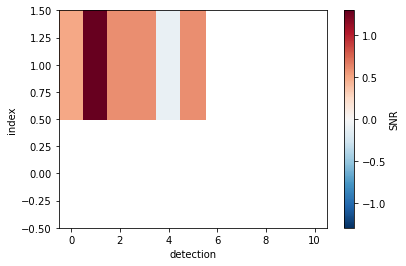

In [8]:
D[1].isel(signal=0).SNR.plot()